In [ ]:
!pip install -qU langchain-groq langchain langchain-community langgraph qdrant-client sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.3/337.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 15.5 MB/s eta 0:00:00


In [ ]:
import os
import json
from google.colab import userdata
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from typing import TypedDict, List, Dict, Any

In [ ]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
llm = ChatGroq(temperature=0, model_name="openai/gpt-oss-120b")

In [ ]:
student_data_alex = {
    "student_name": "Alex Johnson",
    "recent_grades": [65, 72, 58, 61],
    "assignment_completion_rate": 0.95,
    "class_participation_events": 2,
    "last_login": "5 days ago"
}

student_data_maria = {
    "student_name": "Maria Garcia",
    "recent_grades": [92, 88, 95, 91],
    "assignment_completion_rate": 0.70,
    "class_participation_events": 8,
    "last_login": "1 day ago"
}

In [ ]:
class AnalysisState(TypedDict):
    student_data: Dict[str, Any]
    analysis_findings: List[str]
    core_problem: str
    recommendations: Dict[str, Any]


def fetch_student_data(state):
    print("---NODE: Fetching Student Data---")
    student_data = state["student_data"]
    return {"student_data": student_data}

# Analyze Raw Data
def analyze_data(state):
    print("---NODE: Analyzing Data---")
    student_data = state["student_data"]
    findings = []

    # Rule 1: Check average grade
    avg_grade = sum(student_data["recent_grades"]) / len(student_data["recent_grades"])
    if avg_grade < 70:
        findings.append(f"The student's average grade is low ({avg_grade:.0f}%).")

    # Rule 2: Check assignment completion
    if student_data["assignment_completion_rate"] < 0.8:
        findings.append(f"The assignment completion rate is low ({student_data['assignment_completion_rate'] * 100:.0f}%).")

    # Rule 3: Check engagement signals
    if student_data["class_participation_events"] < 3:
        findings.append("Class participation is very low.")
    if "days ago" in student_data["last_login"] and int(student_data["last_login"].split(" ")[0]) > 3:
        findings.append("The student has not logged in recently.")

    print(f"Findings: {findings}")
    return {"analysis_findings": findings}

# Identify the Core Problem
# This node uses the LLM to synthesize the findings into a single, high-level problem statement.
def identify_core_problem(state):
    print("---NODE: Identifying Core Problem---")
    findings = state["analysis_findings"]

    if not findings:
        return {"core_problem": "No significant issues identified. Student is performing well."}

    prompt = f"""
    Based on the following analytical findings about a student, synthesize them into a single, core problem statement.
    The problem statement should be a concise summary of the root cause.

    Analytical Findings:
    - {"\n- ".join(findings)}

    Core Problem Statement:
    """

    response = llm.invoke(prompt)
    problem = response.content
    print(f"Identified Problem: {problem}")
    return {"core_problem": problem}

# Generate Actionable Recommendations
# This node takes the core problem and uses the LLM to suggest concrete actions for the teacher.
def generate_recommendations(state):
    print("---NODE: Generating Recommendations---")
    problem = state["core_problem"]
    student_name = state["student_data"]["student_name"]

    if "No significant issues" in problem:
        return {"recommendations": {"summary": "No intervention needed.", "steps": ["Acknowledge student's good work."] }}

    prompt = f"""
    You are an expert educational strategist. For a student named {student_name}, the core problem identified is:
    "{problem}"

    Based on this problem, generate a short, actionable intervention plan for the teacher.
    Provide your response as a JSON object with two keys: "summary" (a one-sentence summary of the plan) and "steps" (a list of 2-3 concrete, actionable steps the teacher can take).

    Example Format:
    {{
        "summary": "A brief summary of the intervention strategy.",
        "steps": [
            "First concrete action step.",
            "Second concrete action step.",
            "Third concrete action step."
        ]
    }}

    JSON Response:
    """

    response = llm.invoke(prompt)
    recommendations = json.loads(response.content)
    print(f"Generated Recommendations: {recommendations}")
    return {"recommendations": recommendations}

In [ ]:
workflow = StateGraph(AnalysisState)

workflow.add_node("fetch_student_data", fetch_student_data)
workflow.add_node("analyze_data", analyze_data)
workflow.add_node("identify_core_problem", identify_core_problem)
workflow.add_node("generate_recommendations", generate_recommendations)

workflow.set_entry_point("fetch_student_data")
workflow.add_edge("fetch_student_data", "analyze_data")
workflow.add_edge("analyze_data", "identify_core_problem")
workflow.add_edge("identify_core_problem", "generate_recommendations")
workflow.add_edge("generate_recommendations", END)


app = workflow.compile()


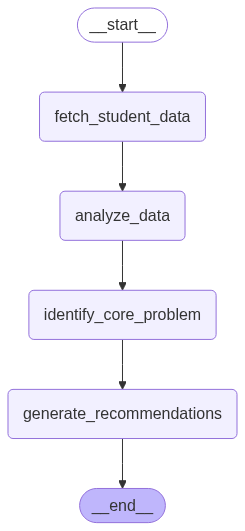

In [ ]:
app

In [ ]:
print("RUNNING ANALYSIS FOR ALEX")
inputs1 = {"student_data": student_data_alex}
result1 = app.invoke(inputs1)

print("\nFINAL RECOMMENDATION FOR ALEX")
print(f"Summary: {result1['recommendations']['summary']}")
for i, step in enumerate(result1['recommendations']['steps']):
    print(f"{i+1}. {step}")

print("\n\n================================\n\n")

#Maria (Good grades but low completion)
print("RUNNING ANALYSIS FOR MARIA")
inputs2 = {"student_data": student_data_maria}
result2 = app.invoke(inputs2)

print("\nFINAL RECOMMENDATION FOR MARIA ")
print(f"Summary: {result2['recommendations']['summary']}")
for i, step in enumerate(result2['recommendations']['steps']):
    print(f"{i+1}. {step}")

RUNNING ANALYSIS FOR ALEX
---NODE: Fetching Student Data---
---NODE: Analyzing Data---
Findings: ["The student's average grade is low (64%).", 'Class participation is very low.', 'The student has not logged in recently.']
---NODE: Identifying Core Problem---
Identified Problem: **Core Problem Statement:**  
The student's insufficient engagement—evidenced by infrequent class participation and recent lack of login—has led to poor academic performance, reflected in a low average grade of 64%.
---NODE: Generating Recommendations---
Generated Recommendations: {'summary': "Increase Alex's engagement through personalized outreach, structured participation incentives, and targeted support sessions.", 'steps': ['Send a personalized email or message to Alex offering a brief one‑on‑one check‑in to discuss any barriers to participation and set a short‑term goal for class involvement.', 'Implement a participation rubric that awards small points for any form of contribution (e.g., answering a questi